In [1]:
import cPickle

# Plotting stuff
# import matplotlib
# For a while I could only prevent GTK loading by using matlab in PDF mode
# but apparently we could get away with just setting inline
# matplotlib.use("Pdf")
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

In [1]:
from blocks.extensions.saveload import load

Using gpu device 1: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [26]:
rnn_type = 'lstm'

ml = load(open("seqgen_" + rnn_type + ".pkl"))
rnn_sample = ml.model.get_theano_function()

param_dict = ml.model.get_parameter_dict()

char_to_ind = cPickle.load(open("char_to_ind.pkl"))

In [3]:
def get_model_var(layer_n, var_type):
#     value_type can either be "state" or "cells"
    cg_path_tpl = "/sequencegenerator/with_fake_attention/transition/layer#{0}.initial_{1}"
    return param_dict[cg_path_tpl.format(layer_n, var_type)]

In [23]:
def lstm_reads(chr_seq):
    
    init_state0 = get_model_var(0, 'state')
    init_state1 = get_model_var(1, 'state')
    init_state2 = get_model_var(2, 'state')
    init_cells0 = get_model_var(0, 'cells')
    init_cells1 = get_model_var(1, 'cells')
    init_cells2 = get_model_var(2, 'cells')
    
    chr_ids = [char_to_ind[char] for char in chr_seq]
    memory_cells = []
    with preserve_state([init_state0, init_state1, init_state2, init_cells0, init_cells1, init_cells2]):
        for chr_id in chr_ids:
            new_state0, new_cells0, new_state1, new_cells1, new_state2, new_cells2, current_char, cost = rnn_sample([[chr_id]])
            init_state0.set_value(new_state0[0][0])
            init_state1.set_value(new_state1[0][0])
            init_state2.set_value(new_state2[0][0])
            init_cells0.set_value(new_cells0[0][0])
            init_cells1.set_value(new_cells1[0][0])
            init_cells2.set_value(new_cells2[0][0])
            vals = init_cells2.get_value()
            memory_cells.append(vals)
    
    return (np.column_stack(memory_cells), np.array(chr_ids))
        

In [22]:
from contextlib import contextmanager

@contextmanager
def preserve_state(shared_variables):
    original_values = [var.get_value() for var in shared_variables]
    yield
    for var, orig in zip(shared_variables, original_values):
        var.set_value(orig)

## Going through character sequence

In [35]:
cats = lstm_reads('cats eat mice')
input_positions = np.arange(len(cats[1]))

### Plotting Stuff...

This for now is just a demo of how easy it is to get at the various components of an NN and plot them

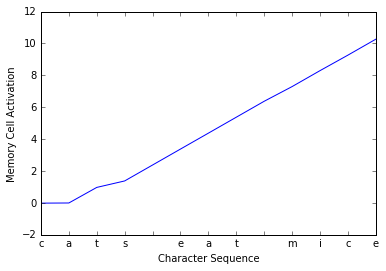

In [36]:
# ranges from 0 to len(input_char_seq) - 1
# keep cell index 11 in mind
plt.plot(cats[0][11])
plt.ylabel("Memory Cell Activation")
plt.xlabel("Character Sequence")
# sets char IDs as tick labels on the X axis
plt.xticks(input_positions, list("cats eat mice"))
plt.show()

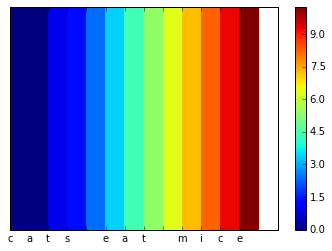

In [37]:
plt.pcolormesh(np.expand_dims(cats[0][11], axis=0))
# sets char IDs as tick labels on the X axis
plt.xticks(input_positions, list("cats eat mice"))
plt.yticks([])
plt.ylim(0, 0.1)
plt.colorbar()
plt.show()

## Hinton Diagrams

In [11]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

    ax.patch.set_facecolor('gray')
#     ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [27]:
randomness = np.random.rand(300,20) - 0.5

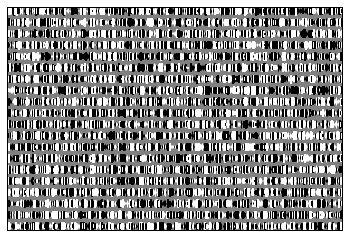

In [28]:
hinton(randomness)